In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from xhistogram.xarray import histogram
from matplotlib import colors as cols
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

plt.rcParams.update({'font.size': 16})

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*4)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.207:39880 Dashboard: http://10.148.0.207:8787/status,Cluster Workers: 56 Cores: 56 Memory: 894.32 GiB


_________
# 1. Read dataset



In [5]:
# Vorticity/f
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [6]:
# Strain/f
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [7]:
D = [xr.open_zarr(out_dir_store+'KE_NI_filter_d%02d.zarr'%(depth)) for depth in range(52)]
KE_NI_filter = xr.concat(D, dim='depth')
KE_NI_filter = KE_NI_filter.KE_NI_single

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

KE_NI_filter = KE_NI_filter.assign_coords(time=time_day) 
KE_NI_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


____________
# WKB scaling

In [8]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [9]:
import xgcm
from xgcm.autogenerate import generate_grid_ds
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


In [10]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')

In [11]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)
db_dz

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,115882 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [12]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

In [13]:
from scipy.signal import butter, filtfilt
lowcut = 1/24/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq

b, a = butter(4, low, 'low')

In [15]:
WKB_scaling = np.abs(db_dz_mean/db_dz_filter)
WKB_scaling

,Array,Chunk
Bytes,64.89 GiB,1.87 MiB
Shape,"(9415, 201, 177, 52)","(9415, 1, 1, 52)"
Count,614563 Tasks,35577 Chunks
Type,float32,numpy.ndarray


In [16]:
from functools import partial
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
db_dz = db_dz.chunk(chunks)

# filter
db_dz_filter = butter_filter(db_dz, b, a)
db_dz_mean = db_dz.mean('depth')
WKB_scaling = np.abs(db_dz_mean/db_dz_filter)
WKB_scaling = np.real(WKB_scaling).rename('WKB_scaling')
WKB_scaling = WKB_scaling.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 1, 'lon': 177, 'depth':1}
WKB_scaling = WKB_scaling.chunk(chunks)
print(WKB_scaling)

# save
file_out = out_dir_zarr+'/WKB_scaling.zarr'
%time WKB_scaling.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:      (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time         (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat          (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon          (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth        (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
Data variables:
    WKB_scaling  (time, lat, lon, depth) float32 dask.array<chunksize=(9415, 1, 177, 1), meta=np.ndarray>
CPU times: user 3min 41s, sys: 4.87 s, total: 3min 46s
Wall time: 4min 17s


In [17]:
# WKB_scaling
WKB_scaling = xr.open_zarr(out_dir_zarr+'WKB_scaling.zarr')
WKB_scaling

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 201, 177, 52)","(9415, 1, 177, 1)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


Text(0.5, 0, '')

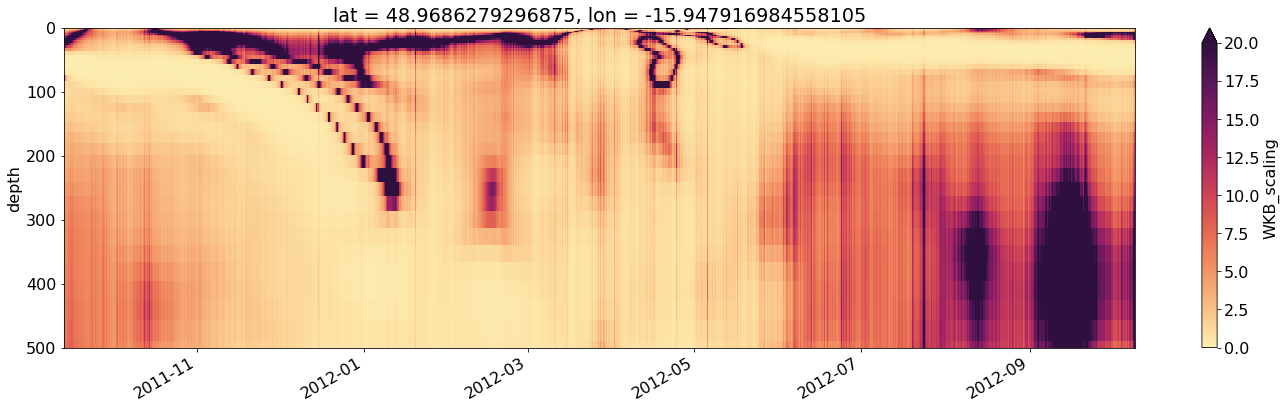

In [18]:
fig = plt.figure(figsize=(24,20))

ax = plt.subplot(311)
WKB_scaling.WKB_scaling.isel(lat=120,lon=100).plot(x='time', y='depth',vmin=0,vmax=20,cmap=cm.matter, yincrease=False)
ax.set_ylim(500, 0)
plt.xlabel('')

# 2. Merge and time series

In [19]:
ds_vs = xr.merge([zeta,strain,KE_NI_filter,WKB_scaling])
print(ds_vs)
print('\n data size: %.1f GB' %(ds_vs.nbytes / 1e9))

<xarray.Dataset>
Dimensions:        (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth          (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat            (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon            (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    zeta_single    (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>
    strain_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    KE_NI_single   (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    WKB_scaling    (time, lat, lon, depth) float32 dask.array<chunksize=(9415, 1, 177, 1), meta=np.ndarray>

 data size: 278.7 GB


Text(0.5, 0, '')

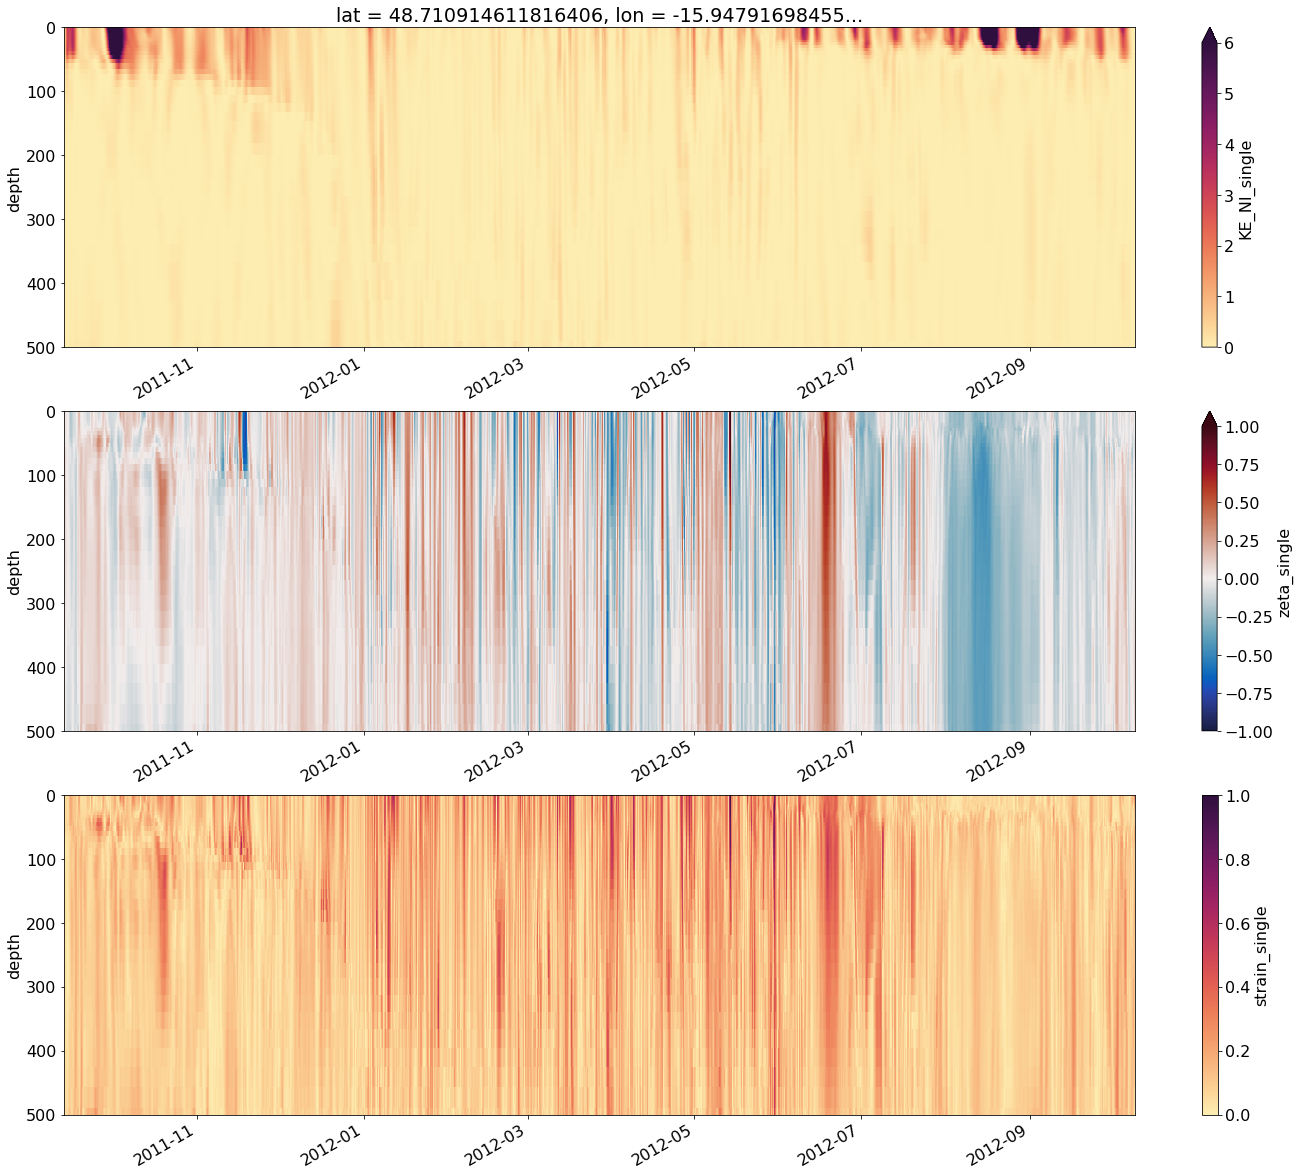

In [21]:
fig = plt.figure(figsize=(24,20))

ax = plt.subplot(311)
ds_vs.KE_NI_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=6,cmap=cm.matter, yincrease=False)
ax.set_ylim(500, 0)
plt.xlabel('')

ax = plt.subplot(312)
ds_vs.zeta_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
ax.set_title('')
plt.xlabel('')

ax = plt.subplot(313)
ds_vs.strain_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1,cmap=cm.matter, yincrease=False)
ax.set_ylim(500, 0)
ax.set_title('')
plt.xlabel('')

_________
# NIKE on vorticity-strain space

In [20]:
KE_NI_scaling = ds_vs.KE_NI_single*ds_vs.WKB_scaling
KE_NI_scaling

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,62765 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [21]:
ndepth = [10, 21, 28, 39]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= KE_NI_scaling.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.563230.datarmor0/ipykernel_37866/2912438216.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.563230.datarmor0/ipykernel_37866/2912438216.py:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.563230.datarmor0/ipykernel_37866/2912438216.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Ei

Text(0.5, 1.0, 'NIKE$_{500m}$ on [$\\zeta$,$\\sigma$]$_{500m}$')

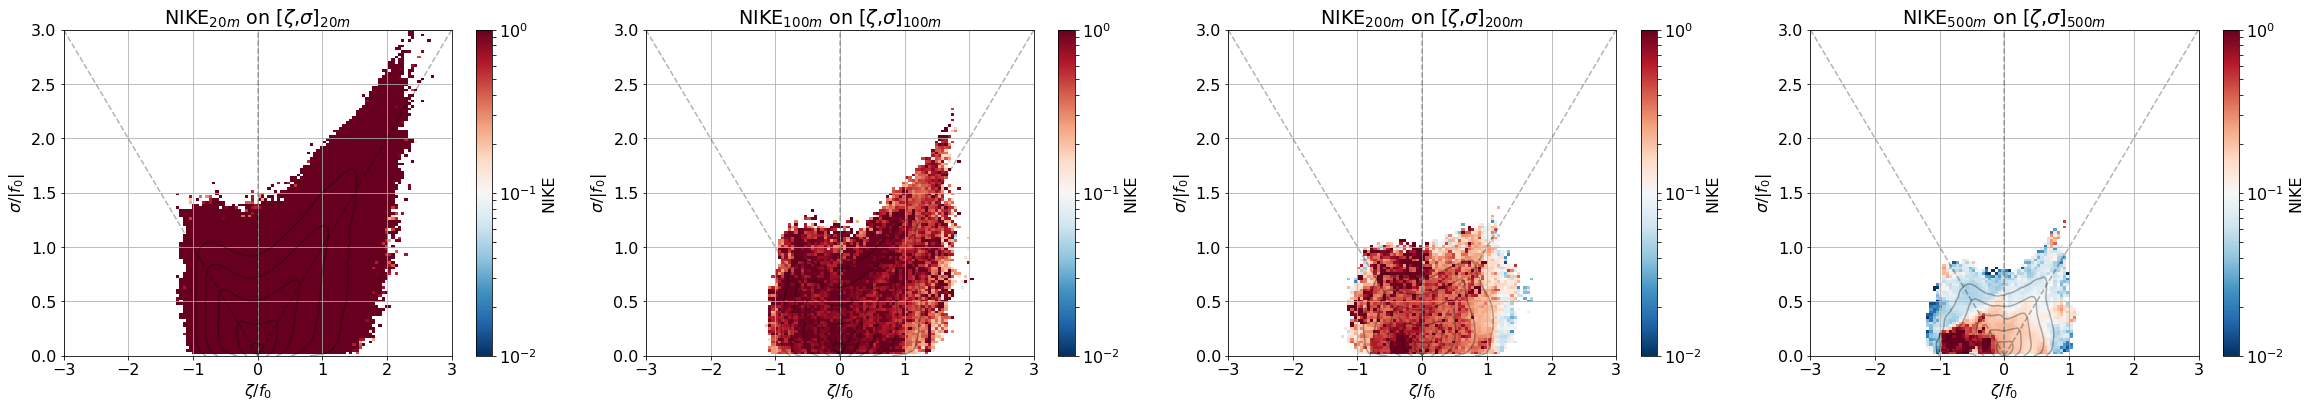

In [22]:
# NIKE
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01


fig, ax = plt.subplots(figsize=(40,6))


ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=1e-2,norm=cols.SymLogNorm(1e-2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('NIKE')
ax.set_title('NIKE$_{20m}$ on [$\zeta$,$\sigma$]$_{20m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
              vmax=1e0,vmin=1e-2,norm=cols.SymLogNorm(1e-2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('NIKE')
ax.set_title('NIKE$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
              vmax=1e0,vmin=1e-2,norm=cols.SymLogNorm(1e-2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('NIKE')
ax.set_title('NIKE$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
              vmax=1e0,vmin=1e-2,norm=cols.SymLogNorm(1e-2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('NIKE')
ax.set_title('NIKE$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')


/dev/shm/pbs.563230.datarmor0/ipykernel_37866/3636418557.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.563230.datarmor0/ipykernel_37866/3636418557.py:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.563230.datarmor0/ipykernel_37866/3636418557.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Ei

Text(0.5, 1.0, 'NIKE$_{200m}$ on [$\\zeta$,$\\sigma$]$_{200m}$')

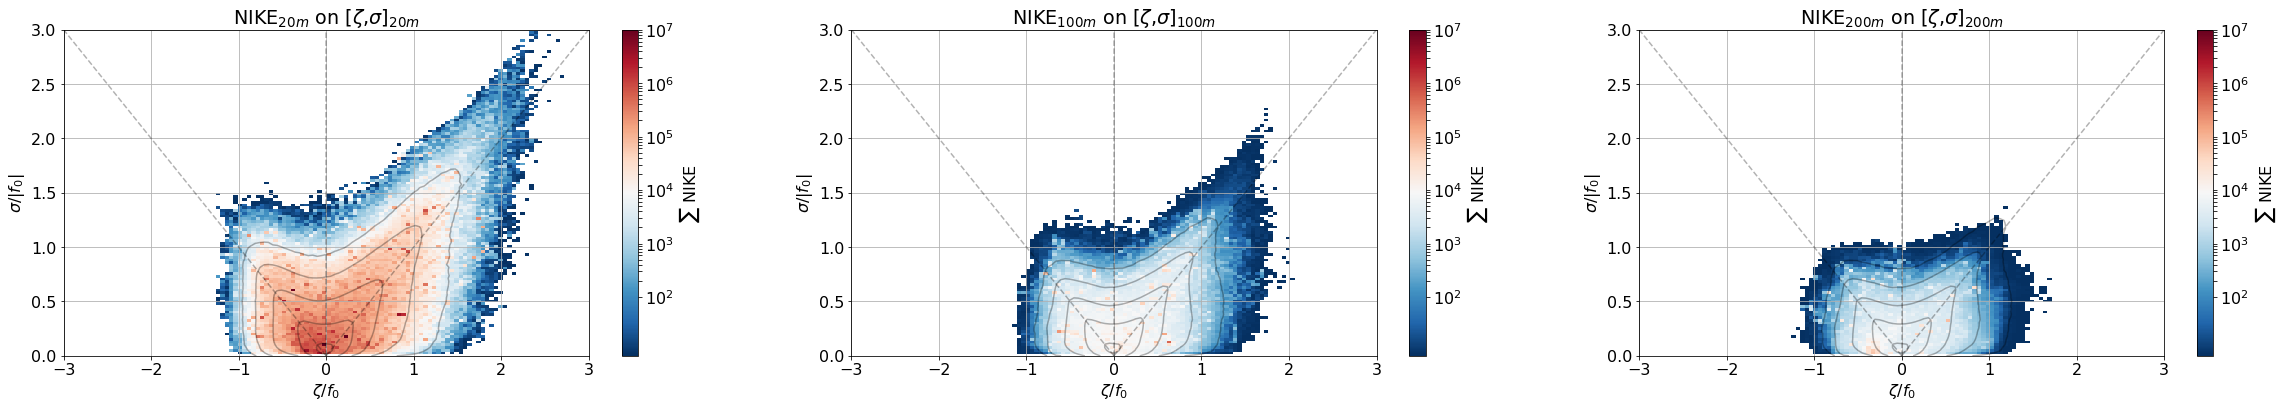

In [25]:
# cumulative NIKE
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).sum(dim='time').T)*filter01


fig, ax = plt.subplots(figsize=(40,6))


ax = plt.subplot(131)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e7,vmin=1e0,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ NIKE')
ax.set_title('NIKE$_{20m}$ on [$\zeta$,$\sigma$]$_{20m}$')


ax = plt.subplot(132)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e7,vmin=1e0,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ NIKE')
ax.set_title('NIKE$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(133)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e7,vmin=1e0,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ NIKE')
ax.set_title('NIKE$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')



In [27]:
cluster.close()